<a href="https://colab.research.google.com/github/Jawakar-7/Lesion-Detection-using-Mammograms/blob/main/Lesions_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! git clone https://github.com/Jawakar-7/Lesion-Detection-using-Mammograms

Cloning into 'Lesion-Detection-using-Mammograms'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (12/12), 58.78 KiB | 4.90 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [5]:
! mkdir ~/.kaggle
! cp /kaggle/working/Lesion-Detection-using-Mammograms/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d skooch/ddsm-mammography

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100%|██████████████████████████████████████▉| 2.88G/2.88G [00:16<00:00, 217MB/s]
100%|███████████████████████████████████████| 2.88G/2.88G [00:16<00:00, 193MB/s]


In [7]:
import zipfile
path= '/kaggle/working/ddsm-mammography.zip'  #  path to  zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')  #extraction path


In [38]:
# import dependencies
import glob
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [26]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }
Image_height = 224
Image_width = 224

## Data Extraction and Preprocessing

In [27]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    
    return parsed_example

In [28]:
def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))

    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    i=0
    for image_features in full_dataset:
        i+=1
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])
        image=image.numpy()
        image=cv2.resize(image,(Image_height,Image_width))
        image=cv2.merge([image,image,image])

        images.append(image)
        labels.append(image_features['label_normal'].numpy())
#         if i<=1:
#           plt.imshow(image)
#           print(image_features['label_normal'].numpy())
    del i

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
0
<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
0
<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Size of Training Dataset:  11177
<_ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)

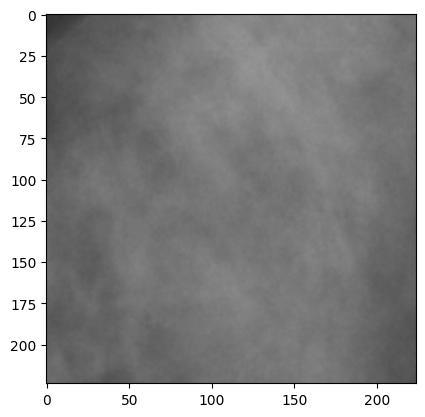

In [29]:
filenames=[
    '/kaggle/working/training10_0/training10_0.tfrecords',
    '/kaggle/working//training10_1/training10_1.tfrecords',
    '/kaggle/working/training10_2/training10_2.tfrecords',

          ]

for file in filenames:
    read_data(file)


In [30]:
print(len(images))


33531


(224, 224, 3)


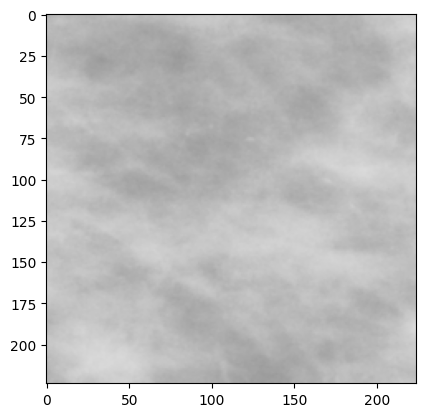

In [31]:
images = np.array(images)
labels = np.array(labels)



plt.imshow(images[19])
print(images[0].shape)

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, stratify = labels, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.50, stratify = y_test, random_state=50)

## Transfer Learning using VGG16

In [35]:
in_lay = Input(x_train.shape[1:])
base_pretrained_model = VGG16(input_shape = x_train.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_features = base_pretrained_model(in_lay)
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)
# here we do an attention mechanism to turn pixels in the GAP on an off
attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = LocallyConnected2D(1, 
                                kernel_size = (1,1), 
                                padding = 'valid', 
                                activation = 'sigmoid')(attn_layer)
                        
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)

# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'sigmoid')(dr_steps)

final_model = Model(inputs = [in_lay], outputs = [out_layer])


In [36]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['input_3[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 7, 7, 512)   2048        ['vgg16[1][0]']                  
 rmalization)                                                                                     
                                                                                            

## Hyperparameter Tuning Methods

In [39]:
weight_path="{}_weights.best.keras".format('breast_cancer')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.00001)
#reduceLROnPlat = ReduceLROnPlateau()
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [41]:
final_model.compile(tf.keras.optimizers.Adam(learning_rate=.001), 
              loss='binary_crossentropy', 
              metrics=['acc'])
     

# train the model

history = final_model.fit(x_train, y_train, 
                          steps_per_epoch=len(x_train)//8,
                          epochs=10,
                          validation_data = (x_val, y_val),
                          validation_steps = len(x_val)//8, 
                          callbacks = callbacks_list
                        )

loss_value , accuracy = final_model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))
     


Epoch 1/10
3353/3353 [==============================] - 158s 46ms/step - loss: 0.1725 - acc: 0.9334 - lr: 0.0010
Epoch 2/10
3353/3353 [==============================] - 153s 46ms/step - loss: 0.1666 - acc: 0.9333 - lr: 0.0010
Epoch 3/10
3353/3353 [==============================] - 153s 46ms/step - loss: 0.1630 - acc: 0.9354 - lr: 0.0010
Epoch 4/10
3353/3353 [==============================] - 153s 46ms/step - loss: 0.1570 - acc: 0.9397 - lr: 0.0010
Epoch 5/10
3353/3353 [==============================] - 153s 46ms/step - loss: 0.1508 - acc: 0.9415 - lr: 0.0010
Epoch 6/10
3353/3353 [==============================] - 153s 46ms/step - loss: 0.1481 - acc: 0.9429 - lr: 0.0010
Epoch 7/10
3353/3353 [==============================] - 153s 46ms/step - loss: 0.1466 - acc: 0.9424 - lr: 0.0010
Epoch 8/10
3353/3353 [==============================] - 153s 46ms/step - loss: 0.1477 - acc: 0.9420 - lr: 0.0010
Epoch 9/10
3353/3353 [==============================] - 153s 46ms/step - loss: 0.1407 - acc: 0.9